# Hops Classification

Hops라는 식물의 병충해 정도를 분류하는 문제.
1102개의 이미지와 레이블로 구성된 데이터셋.

* Input : Hops 식물 사진
* Output : 5개의 클래스 중 하나

클래스는 다음과 같이 5개의 클래스로 구성됨

* Healthy
* Nutrient
* Disease-Downy
* Disease-Powdery
* Pests

다운로드 링크 : 
[https://www.kaggle.com/scruggzilla/hops-classification](https://www.kaggle.com/scruggzilla/hops-classification)

데이터를 다운받고 COLAB 파일이 있는 구글 드라이브의 경로에 저장해주세요.

### 사용 가능한 GPU 확인하기

In [ ]:
!nvidia-smi

Wed Mar 30 09:11:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 구글 드라이브 마운트 + 구글 드라이브에 있는 Hops 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

drive_dir = "/content/drive/MyDrive/"
data_dir = os.path.join(drive_dir, "colab", "CNU_AI_TEAMWORK", "Hops") # 자신의 환경에 맞게끔 경로를 셋팅해주세요.
data_dir

'/content/drive/MyDrive/colab/CNU_AI_TEAMWORK/Hops'

### PyTorch Lightning 다운로드

In [4]:
!pip install pytorch-lightning

     |████████████████████████████████| 584 kB 5.1 MB/s 
     |████████████████████████████████| 409 kB 36.4 MB/s 
     |████████████████████████████████| 136 kB 60.1 MB/s 
     |████████████████████████████████| 596 kB 51.7 MB/s 
     |████████████████████████████████| 1.1 MB 46.0 MB/s 
     |████████████████████████████████| 271 kB 67.5 MB/s 
     |████████████████████████████████| 144 kB 66.6 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### 필요 라이브러리 Import

In [5]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl

### COLAB에서 이미지 파일을 불러올 때 오류가 나지 않게 하기 위해서

In [ ]:
# Pillow 설치가 안 되어 있다면 다음 코드의 주석을 해제하고 실행

#!pip install pillow

In [ ]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### 이미지 데이터 확인

In [ ]:
image_data1 = os.path.join(data_dir, "Disease-Downy", "1.jpg")

image1 = Image.open(image_data1)
image1_np = np.array(image1)

image1_np.shape

(768, 1024, 3)

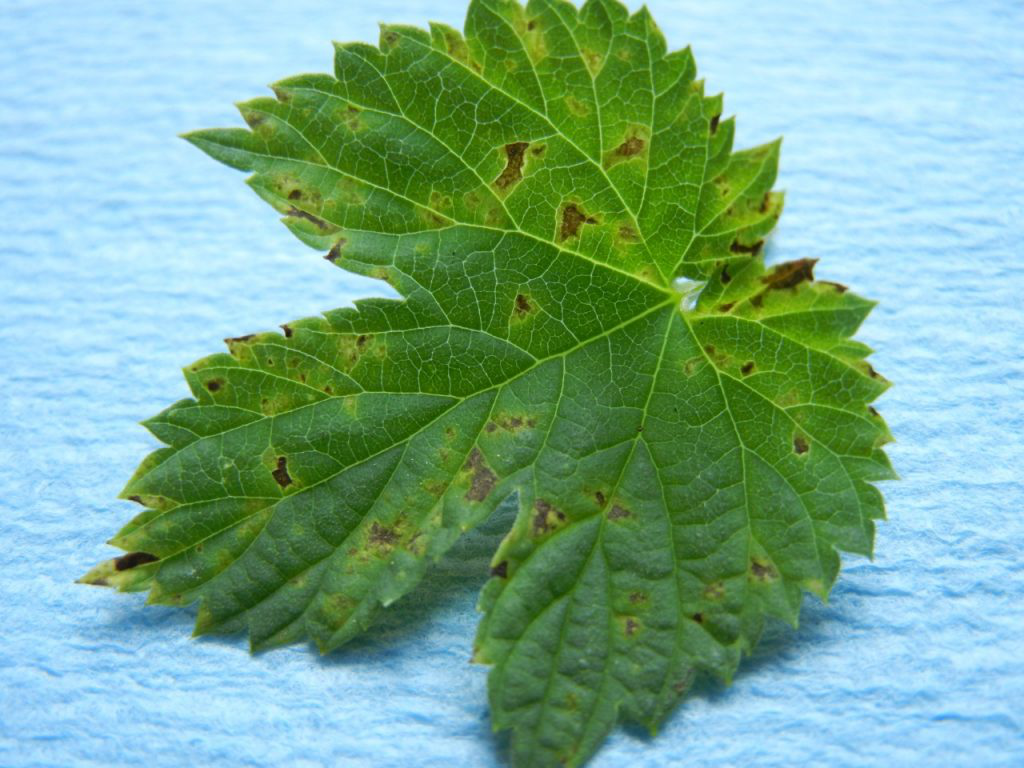

In [ ]:
image1

In [ ]:
image_data2 = os.path.join(data_dir, "Disease-Downy", "2.jpg")

image2 = Image.open(image_data2)
image2_np = np.array(image2)

image2_np.shape

(423, 318, 3)

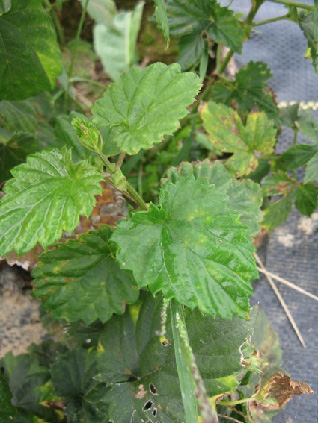

In [ ]:
image2

### 5 개의 층으로 구성된 MLP 모델을 활용하여 분류하기

In [ ]:
class HopClassification(pl.LightningModule):
    def __init__(self, data_dir, batch_size, image_size):
        super(HopClassification, self).__init__()

        self.data_dir = data_dir
        self.transform = transforms.Compose([
          transforms.Resize((image_size, image_size)),                                        
          transforms.ToTensor()
        ])
        self.batch_size = batch_size

        self.layer_1 = nn.Linear(image_size * image_size * 3, 512)
        self.layer_2 = nn.Linear(512, 256)
        self.layer_3 = nn.Linear(256, 128)
        self.layer_4 = nn.Linear(128, 64)
        self.layer_5 = nn.Linear(64, 5)

    def forward(self, x): 
        batch_size, channelds, width, height = x.size()

        # (batch_size, 3, image_size, image_size) -> (batch_size, 3*image_size*image_size)
        x = x.view(batch_size, -1)

        # layer 1
        x = torch.relu(self.layer_1(x))

        # layer 2
        x = torch.relu(self.layer_2(x))
        
        # layer 3
        x = torch.relu(self.layer_3(x))
        
        # layer 4
        x = torch.relu(self.layer_4(x))

        # layer 5
        x = self.layer_5(x)

        # probability distribution over labels
        x = torch.log_softmax(x, dim=1)

        return x

    def prepare_data(self):
        dataset = ImageFolder(data_dir, transform=self.transform)
        
        # split dataset to train, val, test ! ==> 0.8 / 0.1 / 0.1
        train_dataset, test_dataset = random_split(dataset, [int(len(dataset) * 0.8), (len(dataset) - int(len(dataset) * 0.8))])
        val_dataset, test_dataset = random_split(test_dataset, [int(len(test_dataset) * 0.5), len(test_dataset) - int(len(test_dataset) * 0.5)])

        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = StepLR(optimizer, step_size=1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        data, target = batch

        output = self(data)
        loss = F.nll_loss(output, target)

        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch

        output = self(data)
        loss = F.nll_loss(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        return {"val_loss" : loss, "correct" : correct}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss' : avg_loss}
        self.log("val_loss", avg_loss, prog_bar=True)
        return {'avg_val_loss' : avg_loss, 'log' : tensorboard_logs}

    def test_step(self, batch, batch_idx):
        data, target = batch

        output = self(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        return {"correct": correct}

    def test_epoch_end(self, outputs):
        all_correct = sum([output["correct"] for output in outputs])
        accuracy = all_correct / len(self.test_dataloader().dataset)
        self.log("Accuracy", accuracy)
        return accuracy

In [ ]:
model = HopClassification(data_dir=data_dir, batch_size=32, image_size=64)

trainer = pl.Trainer(gpus=1, max_epochs=1)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type   | Params
-----------------------------------
0 | layer_1 | Linear | 6.3 M 
1 | layer_2 | Linear | 131 K 
2 | layer_3 | Linear | 32.9 K
3 | layer_4 | Linear | 8.3 K 
4 | layer_5 | Linear | 325   
-----------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
25.859    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1942: PossibleUserWarning: The number of training samples (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.test()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1448: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=0-step=28.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=0-step=28.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Accuracy            0.5045045018196106
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Accuracy': 0.5045045018196106}]

### CNN을 통해 분류하기

In [ ]:
class HopClassificationWithCNN(pl.LightningModule):
    def __init__(self, data_dir, batch_size, image_size):
        super(HopClassificationWithCNN, self).__init__()

        self.data_dir = data_dir
        self.transform = transforms.Compose([
          transforms.Resize((image_size, image_size)),                                        
          transforms.ToTensor()
        ])
        self.batch_size = batch_size

        self.layer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3),
                                 padding=(1, 1), stride=(1, 1))
        self.layer2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3),
                                 padding=(1, 1), stride=(1, 1))
        self.layer3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3),
                                 padding=(1, 1), stride=(1, 1))
        self.layer4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3),
                                 padding=(1, 1), stride=(1, 1))
        self.layer5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3),
                                 padding=(1, 1), stride=(1, 1))
        self.layer6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3),
                                 padding=(1, 1), stride=(1, 1))
        self.layer7 = nn.Sequential(
            nn.Linear(512 * (int(image_size / 2 / 2 / 2)) * (int(image_size / 2 / 2 / 2)), 1000),
            nn.Linear(1000, 100)
        )
        self.batch_norm1 = nn.BatchNorm2d(256)
        self.batch_norm2 = nn.BatchNorm2d(512)
        self.batch_norm3 = nn.BatchNorm2d(512)
        self.to_class = nn.Linear(100, 5)

    def forward(self, x): 
        batch_size = x.size(0)
        
        # layer 1 --> Output : (batch_size, 64, imgH/2, imgW/2)
        h = F.relu(self.layer1(x[:, :, :, :] - 0.5), True)
        h = F.max_pool2d(h, kernel_size=(2, 2), stride=(2, 2))

        # layer 2 --> Output : (batch_size, 128, imgH/2/2, imgW/2/2)
        h = F.relu(self.layer2(h), True)
        h = F.max_pool2d(h, kernel_size=(2, 2), stride=(2, 2))
      
        # layer 3 --> Output : (batch_size, 256, imgH/2/2, imgW/2/2)
        h = F.relu(self.batch_norm1(self.layer3(h)), True)

        # layer 4 --> Output : (batch_size, 512, imgH/2/2/2, imgW/2/2)
        h = F.relu(self.layer4(h), True)
        h = F.max_pool2d(h, kernel_size=(1, 2), stride=(1, 2))
        
        # layer 5 --> Output : (batch_size, 512, imgH/2/2/2, imgW/2/2/2)
        h = F.relu(self.batch_norm2(self.layer5(h)), True)
        h = F.max_pool2d(h, kernel_size=(2, 1), stride=(2, 1))

        # layer 6 --> Output : (batch_size, 512, imgH/2/2/2, imgW/2/2/2)
        h = F.relu(self.batch_norm3(self.layer6(h)), True)
        
        # (batch_size, 512, imgH/2/2/2, imgW/2/2/2) --> (batch_size, -1)
        h = h.reshape(h.size(0), -1) 
        
        # (batch_size, -1) --> (batch_size, 100)
        h = self.layer7(h)

        logit = self.to_class(h)
        return logit

    def prepare_data(self):
        dataset = ImageFolder(data_dir, transform=self.transform)
        
        # split dataset to train, val, test ! ==> 0.8 / 0.1 / 0.1
        train_dataset, test_dataset = random_split(dataset, [int(len(dataset) * 0.8), (len(dataset) - int(len(dataset) * 0.8))])
        val_dataset, test_dataset = random_split(test_dataset, [int(len(test_dataset) * 0.5), len(test_dataset) - int(len(test_dataset) * 0.5)])

        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.test_dataset = test_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def configure_optimizers(self):
        param_optimizer = list(self.named_parameters())
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
        optimizer = torch.optim.Adam(optimizer_grouped_parameters, lr=3e-5)
        return optimizer

    def training_step(self, batch, batch_idx):
        data, target = batch

        output = self(data)
        loss = F.cross_entropy(output, target)

        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch

        output = self(data)
        loss = F.cross_entropy(output, target)
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        return {"val_loss" : loss, "correct" : correct}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss' : avg_loss}
        self.log("val_loss", avg_loss, prog_bar=True)
        return {'avg_val_loss' : avg_loss, 'log' : tensorboard_logs}

    def test_step(self, batch, batch_idx):
        data, target = batch

        output = self(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        return {"correct": correct}

    def test_epoch_end(self, outputs):
        all_correct = sum([output["correct"] for output in outputs])
        accuracy = all_correct / len(self.test_dataloader().dataset)
        self.log("Accuracy", accuracy)
        return accuracy

In [ ]:
model = HopClassificationWithCNN(data_dir=data_dir, batch_size=32, image_size=64)

trainer = pl.Trainer(gpus=1, max_epochs=10)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name        | Type        | Params
---------------------------------------------
0  | layer1      | Conv2d      | 1.8 K 
1  | layer2      | Conv2d      | 73.9 K
2  | layer3      | Conv2d      | 295 K 
3  | layer4      | Conv2d      | 590 K 
4  | layer5      | Conv2d      | 1.2 M 
5  | layer6      | Conv2d      | 2.4 M 
6  | layer7      | Sequential  | 32.9 M
7  | batch_norm1 | BatchNorm2d | 512   
8  | batch_norm2 | BatchNorm2d | 1.0 K 
9  | batch_norm3 | BatchNorm2d | 1.0 K 
10 | to_class    | Linear      | 505   
---------------------------------------------
37.4 M    Trainable params
0         Non-trainable params
37.4 M    Total params
149.492   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1942: PossibleUserWarning: The number of training samples (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.test()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1448: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=9-step=280.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/lightning_logs/version_1/checkpoints/epoch=9-step=280.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Accuracy            0.9189189076423645
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Accuracy': 0.9189189076423645}]